# Goal of this notebook

Show what tf-idf ("term frequency, inverse document frequency") is, 
what it does does to terms from documents,
mention why it is used in machne learning, and even alone,
and how it is limited (particularly when used alone).


On the whole, **this is not a very important thing to read**. 
Yes, it can be useful to understand _why_ it is used by some other methods,
yet it is not a tf-idf is _not_ a full method in itself.


## What is tf-idf?

### For context

Say you have a bunch of documents, want some overview, and decide to creating the following table:
- each row represents a documents
- each column represents a term
- each cell count how often each term appears in each document


You can imagine something this might be useful to do things like 
- find words that are unimportant to distinguish these documents, or at all, (because they are in _everything_)
- compare documents (because they use the same less-common words)
- perhaps find similar terms
  - because, having found which documents are similar, you can estimate which terms might be in the same area, or more closely related


At the same time, you can also imagine that just plain counts counts is too simple and has... _issues_
- Longer documents would have higher numbers for terms not because they are more important, but just because there are more words in the document.
- Common words would have high counts not because they are meaningful, but just because they are common.
  - In fact, things like [Zipfian word distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) points out that in natural text,
    common terms are ''disproportionally'' common - a handful like _the_, _be_, _to_, _of_, _and_, _in_, _a_, will cover perhaps 20% of all text,
    while being semantically empty function words.

### Basic motivation of tf-idf

tf-idf was introduced in the 1970s, as a heuristic of 'term specificity', based on 
- the intuition that a term more common in a document is probably important to **that** document
- the intuition that a term common to **all** documents is probably less important in general


**Term frequency** (tf) is often calculated as `(count of term within document / total terms in document)` - so counts expressed as a ratio.

**Document frequency** (df) is often calculated as `log( count of documents / count of documents that contain the term )`.

In **Inverse document frequency** (idf), the word 'inverse' just indicates that we *divide* by this: _idf_ = _1 / df_


These ways of calculating are the basics.
Specific implementations using the tf-idf _idea_ may will often try to be smarter,
but still call it tf-idf (we mention this because if you use someone else's code, it may not show the same values as a tutorial would).

## What does it give you, and what can you do with it?

tf-idf is a means to an end, a tool, rather than a fully fleshed out processing method or goal.

When what you had before was basically a 'bag of words' model (bag of words roughly meaning that you see document as an unordered set of the words it consists of),
what you have with tf-idf is more like a _weighted_ bag of words (set of words, but for each term we have an indication of its value).

Yet that value is somewhat handwavey, and you still have to decide how this is useful to what you want to do.

For example, 
- if you are inspecting a collection of documents for what might be more unique and topical terms, 
you might wish to exclude terms appearing in most documents, just to ignore a lot of muck.

- if you're creating a field-specific stopword list, or perhaps estimate how _not_ to the point a document is, then
the muck is exactly what you are interested in. 

- if you are building a search engine, you can imagine that these weights might be a useful, document-collection-specific
  - e.g. if you're searching in rechtbank data, it will know that of the words in the query, things like 'verzoeker' are less interesting to 


...which is a neat trick for something

### What could you do?

* score results in a search system - idf means putting little weight in things not interested in the document set, tf means focusing more on specifics

* make stopword lists / automatically downweigh repetitive words
  things you would consider stopwords will automatically grow the highest IDF
  and it's a gliding scale with other words that happen to be common

* try to score a document for how repetitive or overcomplete something is

### Limitations

Note that the larger and more heterogenous the document set, the more diluted some effects are,
and some uses stand and fall with a little control.

Say you're comparing all possible media products, then terms like 'film', 'book', 'album' are very distinguishing,
and you may want those to be reported so you can partition them later.

If you're looking at all your products this will be stronger.

If you're looking just within movie reviews, or just within all book reviews, or just album reviews, 
then these are the terms you want to fall away.

IDF, when calculated for such a specific collection, will basically do that for you,
but when you want to do things based on the result, you should be aware of this context sensitivity,
and you may want to do a little more curation.

<!-- -->

You should not assume its output is linear or usable as probabilities - it's ordinal, but distribution is skewed,
so this isn't even very good input to a lot of methods.

It's better than nothing, and e.g. in result scoring the values themselves don't have to make sense.

Applying log will help, but not 

<!-- -->

You should not assume the output lets you do direct comparisons anyway -- 
the numbers you end up with in the table is based on ratios within the document,
which means that longer document have lower values on each term by definition,
which may not match your intuition of how much about certain terms it is.

### Other notes

Whether you see the results of tf-idf calculation as document-by-term matrix that happens to be sparsely filled, or another way,
depends a little on implementation and intent.

Tutorials out there will differ (it seems each field does its own thing).



# ...Okay, how about some examples?

## tf-idf using sklearn

In [38]:
import numpy
import random
import sklearn, sklearn.feature_extraction

In [39]:
class TfIdf:
    ''' This class mostly leverages sklearn's existing tfidf code, 
        and we wrap it into another class 
        mainly to make it slightly easier to feed in documents and inspect the result.

        You don't need to understand this code, and can skip this cell.
    '''
    def __init__(self):
        self.docs     = []
        self.docnames = []
        self.doci     = 1

    def add_document(self, doc_as_term_sequence, docname=None):
        ' takes a document as a string. You can hand in a name, used in the visualization '
        if docname==None:
            docname = 'doc%d'%self.doci
            self.doci += 1
        self.docnames.append( docname )
        self.docs.append( doc_as_term_sequence )

    def calc(self, **kwargs):
        """ mostly just calls sklearn's TfidfVectorizer,
            see also https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer
            
            - min_df ignores terms that appear less than some amount
            - max_df ignores terms that appear more than some amount,
            
              Both min_df and max_df can be an integer (will be used as a count) or a float in 0..1 (will be used as a fraction of the document count)
            
              min_df can e.g. be used to remove things that are probably typos (default is 2, rather than 1)
              max_df can e.g. be used to remove works we use in almost every sentence (default is 1.0, no filtering)

            - max_features selects only the most-occuring terms (term frequency)
        """
        min_df = kwargs.pop('min_df',2)
        max_df = kwargs.pop('max_df',1.0)
        ngram_range = kwargs.pop('ngram_range',(1,1))
        max_features = kwargs.pop('max_features',None)
        stop_words = kwargs.pop('stop_words',None)
        sublinear_tf = kwargs.pop('sublinear_tf',False)
        if len(kwargs) > 0:
            print("Unrecognized kwargs: %s"%', '.join(kwargs.keys()))

        self.vectorizer      = sklearn.feature_extraction.text.TfidfVectorizer( 
            min_df=min_df,   # terms that appear in only one document are assumed to be misspelled or otherwise unimportant
            max_df=max_df,
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words=stop_words,
            sublinear_tf=sublinear_tf,
            use_idf=True, # (true by default)
        )
        # the fit part learns the vocabulary and idf,  the tansform part turns documents into document-term matrices
        self.doc_term_matrix = self.vectorizer.fit_transform( raw_documents=self.docs )
        #print(self.doc_term_matrix)

    def vocab_idf(self):
        ' returns (term, internalfeatureindex, IDF) for the entire vocabulary'
        ret = []
        for term, feati in self.vectorizer.vocabulary_.items():
            ret.append( (term, feati, self.vectorizer.idf_[feati]) )
        ret.sort(key=lambda x:x[2])
        return ret


class ShowTfIdf:
    ' pretty-print such a TfIdf objects   in the context of ipython style notebooks '
    def __init__(self, ob):
        self.ob = ob
    
    def _repr_html_(self):
        ret = []
        if not hasattr(self.ob, 'vectorizer'):
            ret.append('<p>not calc()ulated yet</p>')
        else:
            #M = self.ob.doc_term_matrix.todense()
            M = self.ob.doc_term_matrix
            nM = M/numpy.amax(M)
            ret.append('<table>')
            try:
                names = self.ob.vectorizer.get_feature_names()  # older sklearn
            except AttributeError:
                names = self.ob.vectorizer.get_feature_names_out() 
            
            ret.append('<tr><th></th>')
            for name in names:
                ret.append('<th>%s</th>'%name) # TODO: escape
            ret.append('</tr>')

            num_docs, num_terms = nM.shape
            for doci in range( num_docs ):
                ret.append('<tr>')
                ret.append('<th>%s</th>'%self.ob.docnames[doci])
                for termi in range(num_terms):
                    p = nM[doci,termi]
                    ret.append('<td style="opacity:%.1f">%.3f</td>'%(p,p))
                ret.append('</tr>')
            
            ret.append('</table>')
        return ''.join(ret)

### Toy example
Let's have a tiny small example we can grasp, and that wouldn't be spammy if we printed it

In [40]:
docs = [
    'I am the duck what goes quack',
    'I am a computer program',
    'I am a member of The The',
    'I am the fox',
    'I am the fox in a longer sentence',
]

i_am = TfIdf()
for doc in docs:
    i_am.add_document( doc )

i_am.calc(   # 'do calculation with the documents we told you about'
    min_df=1,     # 'pick up things that appear in at least X documents',  1 means no filtering and is intentional for this tiny an example (e.g. 2 would leave in only 'am', 'the', and 'fox')
    max_df=1.0,   # 'leave out things that appear in at least this fraction of documents' - 1.0 meaning no filtering   (also the default)
)

ShowTfIdf( i_am )

,am,computer,duck,fox,goes,in,longer,member,of,program,quack,sentence,the,what
doc1,0.303,0.000,0.636,0.000,0.636,0.000,0.000,0.000,0.000,0.000,0.636,0.000,0.358,0.636
doc2,0.433,0.908,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.908,0.000,0.000,0.000,0.000
doc3,0.345,0.000,0.000,0.000,0.000,0.000,0.000,0.725,0.725,0.000,0.000,0.000,0.817,0.000
doc4,0.591,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.698,0.000
doc5,0.315,0.000,0.000,0.534,0.000,0.662,0.662,0.000,0.000,0.000,0.000,0.662,0.373,0.000


Things of note: 
- 'am' is downscored, due to being in every document. (the same would happen to 'I', except that it was removed due to our code removing _everything_ of length 1)
- for 'the' we see a mix of decreased score to being everywhere, while still valuing more common occurrence. This also demonstrates that the amount of effect idf should have can be debated
- various words appear in one document, and have varying scores. This is unavoidable because tf-idf is by definition affected by multiple things (e.g. document size, term frequency), though sometimes you want more control over _how much_ each contributes.

- `min_df` removes things that appear in fewer than this many documents (things that occur just once in many documents are likely misspelled words) - less valuable in this particular example because we have so few documents
- `max_df` removes things that appear in more than this many documents (we assume these are probably function words, or otherwise so common that they have no distinguishing value)
  - a max_df that is <1.0 means should appear in this*amount_of_documents, e.g. 0.7 (presumably interpreted as 'at least in 4') would remove 'am' and 'the'

However, we usually don't have terms that are that unique / table that is that sparse. An example on more words:

## Example in unstructured text

In [43]:
import wetsuite.datasets, random
rvs = wetsuite.datasets.load('raadvanstate-adviezen-struc')

# The below gets a subset of documents of similar length
   
count_ignored, count_selected = 0,0
#lengths = []
larger_rvs_advice = []   # (kenmerk, url, body) triples
for key, item in rvs.data.items():
    body = '\n'.join( item['body'] )
    #lengths.append(len(body))
    if len(body) > 3000 and len(body)<12000: 
        larger_rvs_advice.append( (item['meta'].get('Kenmerk',None), item['url'], body) )
        count_selected += 1
    else:
        count_ignored += 1

# the choice of length range is is based on:
#   df = pandas.DataFrame( {'lens':lengths} )
#   df[ df["lens"] >900 ][ df["lens"] <30000 ].hist(  )

print( f'We selected {count_selected} and ignored {count_ignored}, based on length' )

We selected 2546 and ignored 9530, based on length


In [47]:
rvs_selection_tfidf = TfIdf()

rvs_selection = random.sample( larger_rvs_advice, 50 )

for kenmerk, url, body in rvs_selection:
    #rvs_tfidf.add_document( body, docname=kenmerk )

    # that HTML-like thing is absolutely cheating in terms of what you should hand in, but happens to work in visualization
    rvs_selection_tfidf.add_document( body, docname='<a href="%s">%s</a>'%(url, kenmerk) )   

In [48]:
# Notes: 
# - min_df=0.4 means removing all terms that appear in fewer than 40% of documents.
#   This is an aggressive value, roughly asking only for words that show up in a middling amount of documents, 
#   which is not a common use, might well take out many documents's _actual topics_.
#   And note that everything you remove now _can_ have no further effect on calculations.
#   We do this ONLY to to keep that output table smallish, while still giving you _some_ indicating of how it values different words
# - Values like min_df=20, max_df=40 would be counts, and would speak to the the imagination more if you know you added 50,
#   min_df=0.4, max_df=0.8 would be equivalent and keep the same meaning once you feed in more documents
# - you probably want to play with these numbers, stopwords, and more, to get a feel for how much the output varies. 
# - sublinear_tf=True lessens the effect of high counts within a document. (we skip explaining why for now)

rvs_selection_tfidf.calc( # some notes on argments below
    min_df=0.4, # this is _quite_ high 
    max_df=0.8,
    stop_words=['aan','aanhangig','aanleiding','als','bij', 'daarmee', 'daarbij', 'dan', 'dat', 'der', 
                'deze', 'die', 'doen', 'door', 'dus', 'er', 'geen', 'geeft', 'gelet', 'gemaakt', 'heeft',
                'hebben', 'ik', 'ii', 'kan', 'luidt', 'maar', 'naar', 'niet', 'of', 'om', 'ook', 'over',
                'te', 'ten', 'ter', 'tot', 'uit', 'voor', 'na', 'nr', 'zal', 'zie', 'zijn', 'nu'],
    sublinear_tf=True
)

ShowTfIdf( rvs_selection_tfidf )

,10,aandacht,aangepast,aanpassing,aantal,adviseert,advisering,afdeling,andere,artikelen,bedoeld,behorende,bepalingen,besluit,betreffende,betreft,betrekking,bijlage,brengen,derde,dient,echter,eerste,enige,enkele,gaan,gebruik,gehouden,generaal,geschonken,geval,geven,gevoegde,gevolg,gewijzigde,hierbij,houdende,indien,inzake,juli,kamer,kamerstukken,komt,kunnen,lid,maakt,maken,mede,meer,memorie,merkt,moet,moeten,mogelijk,nadat,nemen,nieuwe,nog,nota,oktober,omdat,onder,onderdeel,onderschrijft,ontwerp,opgenomen,opmerking,opmerkingen,overeenkomstig,paragraaf,plaats,redactionele,regeling,rekening,staten,strekking,tekst,toepassing,tussen,verband,verwijst,volgende,voorgestelde,voorstel,voorts,vorenstaande,waarbij,waarin,waarom,wel,wenselijk,wet,wetsvoorstel,wijziging,zaken,zenden,zo,zoals
W06.15.0352/III,0.000,0.000,0.000,0.196,0.000,0.258,0.536,0.822,0.310,0.000,0.209,0.200,0.000,0.746,0.602,0.558,0.165,0.310,0.183,0.219,0.000,0.000,0.172,0.236,0.000,0.000,0.230,0.230,0.000,0.000,0.362,0.000,0.000,0.000,0.268,0.263,0.000,0.000,0.600,0.000,0.000,0.200,0.236,0.000,0.386,0.000,0.000,0.000,0.000,0.000,0.380,0.000,0.000,0.000,0.158,0.401,0.209,0.214,0.559,0.559,0.000,0.000,0.209,0.000,0.236,0.338,0.214,0.187,0.214,0.000,0.224,0.419,0.630,0.196,0.000,0.000,0.204,0.324,0.000,0.000,0.200,0.000,0.439,0.000,0.230,0.162,0.000,0.000,0.000,0.000,0.000,0.152,0.000,0.422,0.000,0.000,0.000,0.000
W08.09.0059/IV,0.428,0.325,0.000,0.368,0.000,0.287,0.000,0.000,0.429,0.325,0.394,0.179,0.201,0.536,0.175,0.179,0.251,0.278,0.164,0.549,0.175,0.000,0.475,0.000,0.000,0.000,0.206,0.350,0.000,0.341,0.325,0.000,0.000,0.000,0.241,0.139,0.318,0.413,0.350,0.000,0.000,0.000,0.000,0.241,0.573,0.278,0.000,0.000,0.172,0.000,0.341,0.000,0.197,0.206,0.241,0.410,0.000,0.000,0.536,0.000,0.000,0.379,0.448,0.197,0.212,0.000,0.000,0.353,0.192,0.212,0.201,0.331,0.311,0.297,0.000,0.201,0.184,0.291,0.184,0.456,0.179,0.000,0.490,0.000,0.493,0.246,0.000,0.201,0.212,0.368,0.188,0.000,0.000,0.246,0.000,0.000,0.000,0.172
W08.04.0110/V,0.000,0.454,0.000,0.000,0.000,0.154,0.000,0.000,0.000,0.000,0.358,0.202,0.000,0.715,0.000,0.000,0.167,0.517,0.185,0.375,0.000,0.000,0.000,0.000,0.000,0.000,0.607,0.000,0.000,0.384,0.000,0.000,0.000,0.000,0.271,0.157,0.358,0.465,0.000,0.000,0.000,0.000,0.239,0.336,0.343,0.000,0.000,0.358,0.328,0.000,0.000,0.202,0.375,0.488,0.271,0.406,0.358,0.217,0.692,0.217,0.000,0.343,0.552,0.000,0.239,0.202,0.217,0.321,0.217,0.404,0.384,0.424,0.207,0.000,0.000,0.000,0.000,0.000,0.000,0.283,0.202,0.000,0.000,0.000,0.000,0.164,0.239,0.227,0.000,0.335,0.000,0.261,0.000,0.662,0.000,0.000,0.000,0.328
W01.14.0052/I,0.644,0.000,0.000,0.000,0.259,0.000,0.438,0.571,0.443,0.247,0.000,0.000,0.259,0.000,0.473,0.231,0.322,0.000,0.000,0.000,0.225,0.000,0.634,0.000,0.225,0.000,0.000,0.000,0.399,0.000,0.247,0.000,0.000,0.000,0.000,0.000,0.241,0.000,0.449,0.000,0.399,0.550,0.000,0.309,0.650,0.000,0.000,0.000,0.000,0.000,0.259,0.390,0.000,0.265,0.000,0.221,0.241,0.247,0.000,0.247,0.543,0.186,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.543,0.000,0.236,0.000,0.586,0.000,0.000,0.576,0.236,0.000,0.000,0.518,0.000,0.000,0.000,0.000,0.460,0.000,0.000,0.473,0.000,0.176,0.000,0.000,0.000,0.000,0.272,0.221
W15.16.0109/IV,0.257,0.275,0.000,0.000,0.000,0.331,0.605,0.723,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.212,0.000,0.000,0.281,0.251,0.000,0.221,0.000,0.251,0.000,0.295,0.000,0.359,0.288,0.000,0.000,0.281,0.000,0.204,0.199,0.269,0.000,0.000,0.000,0.445,0.670,0.000,0.000,0.000,0.000,0.000,0.000,0.246,0.701,0.000,0.000,0.000,0.295,0.204,0.000,0.000,0.466,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.275,0.000,0.275,0.000,0.000,0.000,0.000,0.000,0.359,0.000,0.263,0.000,0.445,0.445,0.000,0.000,0.000,0.835,0.000,0.436,0.000,0.000,0.000,0.000,0.000,0.761,0.000,0.352,0.445,0.591,0.000,0.246
W13.01.0504/III,0.000,0.000,0.000,0.000,0.668,0.294,0.256,0.000,0.498,0.000,0.238,0.228,0.000,0.681,0.000,0.386,0.319,0.354,0.209,0.000,0.377,0.000,0.000,0.000,0.000,0.000,0.550,0.000,0.319,0.000,0

Notes:
- there are many distinct terms, but very few uses of each.
  That sparsity makes document comparison pretty hard (There are various methods that specifically work on this aspect to make documents more comparable)
  
- this will contain _primarily_ fairly-pointless terms  (the long tail of the Zipfian distribution)

- If you _do_ spend a little more time trying and scrolling, you start to notice that while the _very_ bottom of 'things that show up in at most a few documents' is muck
  - yet at some point it transitions to also contain interesting-but-uncommon.  It turns out you can't really tell them apart from just tf-idf.

In [45]:
# Asking things that appear in almost every document distinguishes very little
rvs_selection_tfidf.calc(min_df=0.9, max_df=1.0, sublinear_tf=True)
ShowTfIdf( rvs_selection_tfidf )

,aanhangig,advies,artikel,bij,de,dit,en,gemaakt,heeft,het,in,is,lid,met,nader,no,op,overweging,president,raad,rapport,reactie,state,te,ter,tot,van,vice,voordracht
W01.09.0503/I,0.176,0.287,0.442,0.499,0.826,0.404,0.655,0.169,0.412,0.664,0.542,0.421,0.377,0.591,0.169,0.173,0.512,0.298,0.363,0.512,0.180,0.183,0.464,0.522,0.173,0.169,0.847,0.173,0.176
W02.21.0015/II,0.244,0.397,0.235,0.492,0.895,0.235,0.549,0.235,0.405,0.678,0.235,0.000,0.421,0.235,0.235,0.239,0.600,0.244,0.239,0.600,0.249,0.254,0.600,0.560,0.239,0.397,0.952,0.239,0.244
W04.13.0280/I,0.182,0.418,0.489,0.457,0.866,0.296,0.636,0.367,0.426,0.648,0.489,0.475,0.314,0.457,0.175,0.179,0.506,0.308,0.179,0.479,0.186,0.321,0.479,0.457,0.179,0.457,0.817,0.179,0.182
W06.19.0248/III,0.219,0.503,0.211,0.503,0.917,0.443,0.540,0.211,0.364,0.683,0.211,0.371,0.379,0.357,0.211,0.364,0.540,0.219,0.215,0.577,0.224,0.228,0.540,0.443,0.215,0.357,0.923,0.215,0.219
W13.07.0379/I,0.167,0.337,0.494,0.448,0.790,0.448,0.561,0.271,0.457,0.707,0.649,0.466,0.524,0.418,0.160,0.277,0.503,0.350,0.164,0.548,0.170,0.173,0.484,0.448,0.277,0.271,0.729,0.164,0.167
W04.17.0153/I,0.231,0.377,0.222,0.377,0.836,0.377,0.609,0.222,0.227,0.760,0.467,0.231,0.399,0.531,0.222,0.227,0.520,0.392,0.227,0.569,0.236,0.241,0.569,0.377,0.227,0.377,0.929,0.227,0.231
W03.00.0564/I,0.157,0.317,0.569,0.526,0.838,0.360,0.436,0.151,0.154,0.735,0.696,0.533,0.271,0.526,0.255,0.261,0.576,0.329,0.154,0.527,0.160,0.163,0.413,0.549,0.154,0.317,0.777,0.154,0.157
W06.10.0528/III,0.133,0.410,0.604,0.423,0.781,0.358,0.565,0.217,0.221,0.670,0.688,0.607,0.619,0.467,0.128,0.221,0.576,0.280,0.131,0.328,0.136,0.139,0.328,0.524,0.341,0.378,0.733,0.131,0.133
W04.19.0402/I,0.212,0.346,0.346,0.204,0.907,0.346,0.681,0.204,0.353,0.743,0.629,0.446,0.367,0.487,0.204,0.208,0.478,0.212,0.208,0.478,0.217,0.221,0.478,0.629,0.353,0.204,0.779,0.208,0.212
W17.24.00044/IV,0.145,0.139,0.363,0.472,0.820,0.506,0.667,0.139,0.338,0.701,0.693,0.666,0.309,0.506,0.139,0.142,0.604,0.145,0.142,0.401,0.147,0.000,0.325,0.555,0.142,0.506,0.774,0.142,0.145


Notes:
- this is so bad that it is _almost_ a a good stopword list in itself. 
- a `max_df` that is <1.0 and smaller can be used to ignore these

In fact, it's not the worst idea to use exactly this to _create_ a stopword list - that adapts to the documents you've fed it.
But as we'll see, there are some words you might not care to remove:

In [71]:
# We've been using the set of 50 until now to be able to view the results,
#   let's switch to the larger set for better word calculations

rvs_all_tfidf = TfIdf() 

for kenmerk, url, body in larger_rvs_advice: # NOTE: this time add all
    #rvs_tfidf.add_document( body, docname=kenmerk )
    rvs_all_tfidf.add_document( body, docname='<a href="%s">%s</a>'%(url, kenmerk) )

print( 'amt documents used:   ', len(larger_rvs_advice) )

rvs_all_tfidf.calc(min_df=0.8)
common = list( word  for word,_,idf in rvs_all_tfidf.vocab_idf() )
print( 'amout of picked terms:', len(common) )
display( common )

amt documents used:    2546
amout of picked terms: 58


['van',
 'met',
 'in',
 'te',
 'de',
 'en',
 'op',
 'raad',
 'state',
 'het',
 'is',
 'een',
 'bij',
 'heeft',
 'gemaakt',
 'voor',
 'aan',
 'dat',
 'ter',
 'overweging',
 'president',
 'vice',
 'aanhangig',
 'dit',
 'tot',
 'no',
 'advies',
 'zijn',
 'nader',
 'die',
 'toelichting',
 'voordracht',
 'majesteit',
 'wordt',
 'niet',
 'uwe',
 'reactie',
 'artikel',
 'worden',
 'rapport',
 'deze',
 'kabinetsmissive',
 'ik',
 'naar',
 'om',
 'adviseert',
 'door',
 'zal',
 'geeft',
 'minister',
 'verzoeken',
 'moge',
 'tweede',
 'lid',
 'ook',
 'gewijzigde',
 'of',
 'hierbij']

# cleaning wordclouds with tf-idf

Word-clouds as-is tend to have a lot of function words that score high because they are uniquitous,
not because they are interesting.

Could we use this to clean that up?

Well, let's try:

In [63]:
class WordcloudTfIdf:
    ' '
    def __init__(self, ob, **kwargs):
        ' any keyword argument are passed through to wordcloud_from_freqs - ensure that makes sense '
        self.ob = ob
        self.kwargs = kwargs
    
    def _repr_png_(self):
        import io
        ret = []
        if not hasattr(self.ob, 'vectorizer'):
            raise ValueError('not calc()ulated yet')
        else:
            M = self.ob.doc_term_matrix
            nM = M/numpy.amax(M)

            try:
                names = self.ob.vectorizer.get_feature_names()  # older sklearn
            except AttributeError:
                names = self.ob.vectorizer.get_feature_names_out() 

            freqs = {}
            # We no longer care about the documents, but we still have that matrix.
            #   Take the sum of the cell values across all documents (there are arguments for percentiles and other ways).
            for name, summ in zip( names, nM.T.sum(axis=1) ):
                freqs[name] = 1/summ.flat[0]
            im = wetsuite.extras.word_cloud.wordcloud_from_freqs( freqs, **self.kwargs )
            by = io.BytesIO()
            im.save(by,'png')
            return by.getvalue()


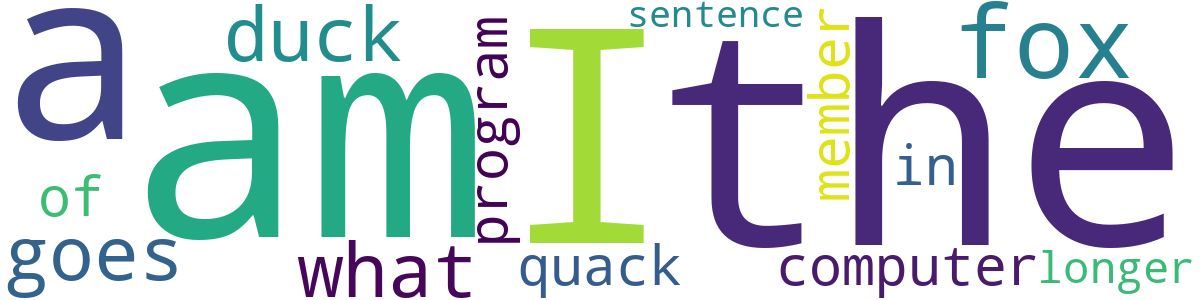

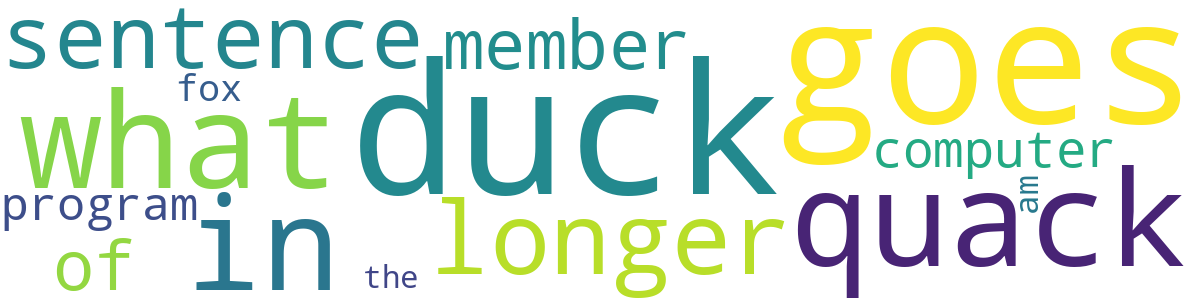

In [66]:
import wetsuite.extras.word_cloud

# naive wordcloud with just frequency
display( wetsuite.extras.word_cloud.wordcloud_from_string( ' '.join(docs) ) )

# slightly smarter wordcloud, using tf-idf to score
display( WordcloudTfIdf( i_am ) )


First the toy example:

Notes:
- since we do a log() is applied along the way, you would expect common things like 'the' to be less overpowering _anyway_, but that alone would not change the order
- 'I', 'am', and 'the' are downscored to be clearly less relevant(would probably get kicked out if there were more than 14 words _at all_)

Okay, what about a more real example?

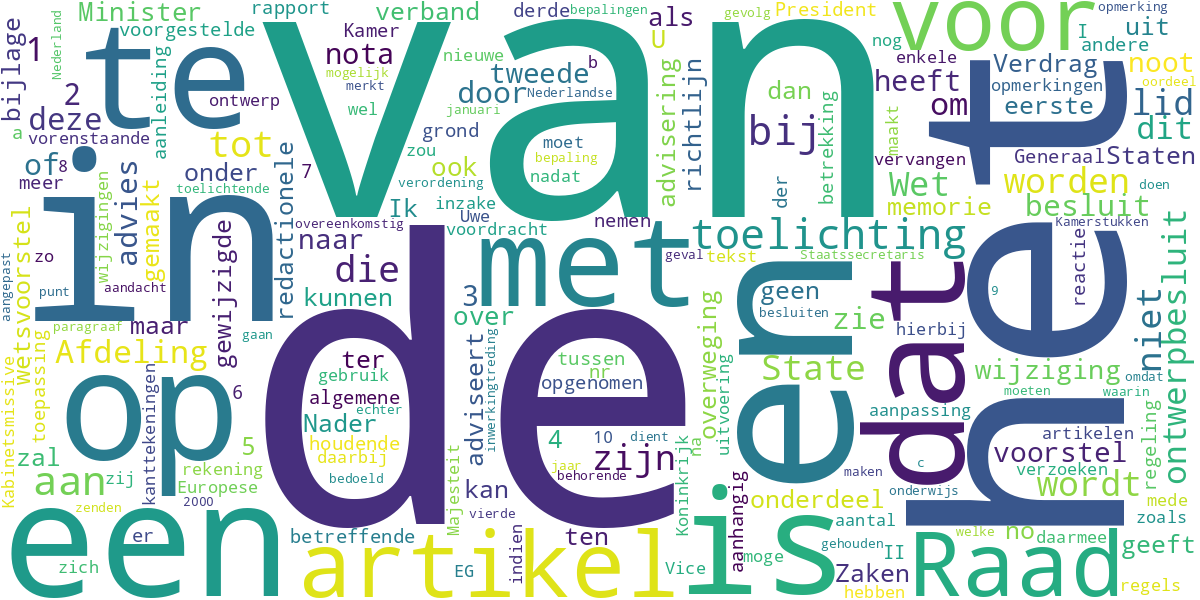

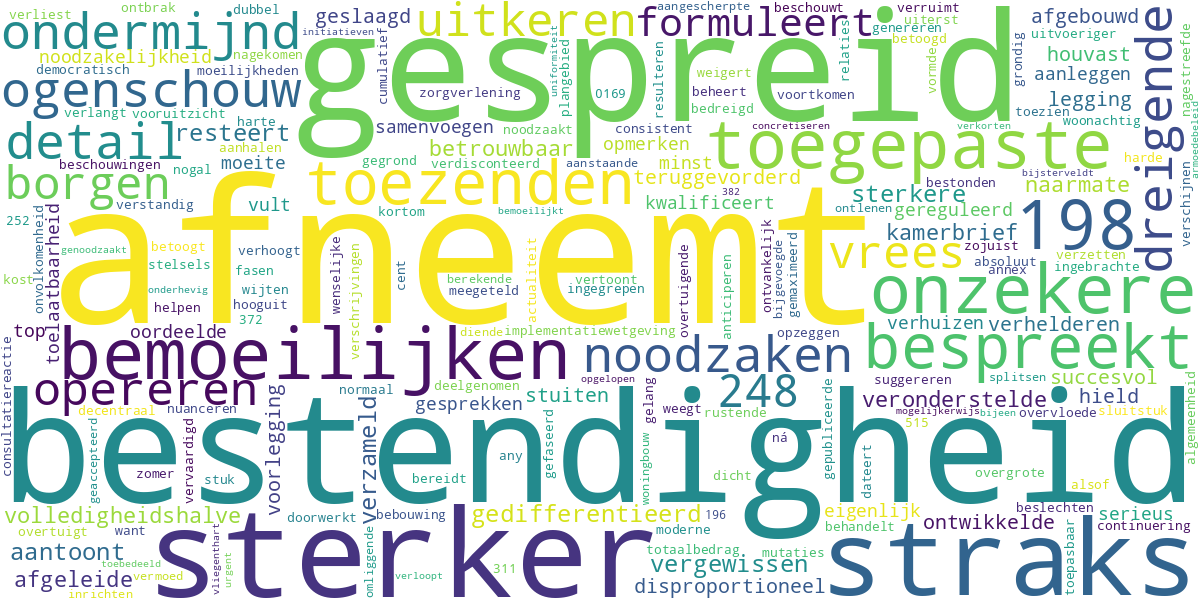

In [84]:
# naive wordcloud with just frequency
display( wetsuite.extras.word_cloud.wordcloud_from_string( ' '.join(text for _,_,text in larger_rvs_advice), height=600 ) )

# slightly smarter wordcloud, using tf-idf to score
rvs_all_tfidf.calc(min_df=10, max_df=0.5, sublinear_tf=True) # recalculate to try to focus on moderately used words
display( WordcloudTfIdf( rvs_all_tfidf, height=600 ) )

That seems better, though not necessarily _great_ -- play with those tf-idf parameters
and you will see they seem to have a little too much effect to be called predictable and robust and comparable to similar output.

We could probably refine this to do better.

## A sense of that idf value

The idf value was the "higher for things that appear in a lot of documents" value.

We've not shown the idf value itself much.
Let's do so, just to show it has a fairly simple meaning:

In [119]:
rvs_all_tfidf.calc( min_df=20, max_df=0.333 ) 

vocab_idf = rvs_all_tfidf.vocab_idf()
for term, _, idf in vocab_idf[:10]: # first ten
    print( '%.3f   %s'%( idf, term) )
print('...')
for term, _, idf in vocab_idf[-10:]: # last ten
    print( '%.3f   %s'%( idf, term) )

# Note that 
# - If you squint, 1 means it's in every document, 2 means it's in half of all documents, 3 means it's in a third;
#   - if you lower max_df, the lowest idf increases
#   - if you increase min_df, it cuts the bottom of the list at a lower idf
# - generally meaning idf is low, near 1.0, for emptier terms like 'am', 'the'
# - this score isn't affected by how often the term appears in a single document, or how much the toal count of appearces is,
#   just by how many documents it appears in.

2.108   toepassing
2.110   gegeven
2.113   inhoudelijke
2.115   moeten
2.122   geval
2.126   passen
2.127   betreft
2.127   volgende
2.129   opmerking
2.134   aandacht
...
6.350   terinzagelegging
6.350   2030
6.350   borgen
6.350   meststoffen
6.350   omroep
6.350   kortingen
6.350   tabaksproducten
6.350   inkomensondersteuning
6.350   armoedebeleid
6.350   hkw


## Do n-grams help?

[N-grams](https://en.wikipedia.org/wiki/N-gram) -- that is, contiguous sequence of words of length n -- will crudely encode some context into the terms.

They will count even more sparsely than the things they are based on, 
though while this is often more of a bug, it can sometimes be a feature.

For example, it can be a good way of identifying common phrases, be a simple approximation of collocation (finding commonly co-occuring words).

The "seen moderately much" filter that was probably bad on words can make more sense around n-grams,
because it helps express "which words appear together a lot" and becomes a crude form of collocation analysis,
though due to context of legal text, this largely finds some more standard phrasing, more than it finds interesting terms.

In [63]:
rvs_selection_tfidf.calc(min_df=10, max_df=30, ngram_range=(3,4), sublinear_tf=True, max_features=100) 
ShowTfIdf( rvs_selection_tfidf )

,aan de tweede,aan de tweede kamer,aan te passen,aanhangig gemaakt het ontwerpbesluit,aanleiding van het,advies van de,advies van de raad,advisering van de,advisering van de raad,afdeling advisering van,afdeling advisering van de,artikel eerste lid,besluit te nemen,bij de afdeling,bij de afdeling advisering,bij de raad,bij de raad van,bij het advies,de afdeling adviseert,de afdeling advisering,de afdeling advisering van,de nota van,de nota van toelichting,de raad adviseert,de staatssecretaris van,de toelichting op,de tweede kamer,de tweede kamer der,de wet op,de wet op de,der staten generaal,dit ontwerp te,dit ontwerp te besluiten,doen toekomen en,doen toekomen en verzoeken,en de gewijzigde,en verzoeken overeenkomstig,en verzoeken overeenkomstig dit,gemaakt het ontwerpbesluit,het advies van de,het voorgestelde artikel,het voorstel van,het voorstel van wet,houdende wijziging van,ik moge hierbij,in de toelichting,in te gaan,in verband met,in verband met de,kamer der staten,kamer der staten generaal,lid van de,lid van de wet,memorie van toelichting,met betrekking tot,met nota van,met nota van toelichting,moge hierbij het,naar aanleiding van,naar aanleiding van het,nota van toelichting,ontwerp te besluiten,ontwerp te besluiten de,ontwerpbesluit en de,op grond van,overeenkomstig dit ontwerp,overeenkomstig dit ontwerp te,raad van state geeft,raad van state nader,raad van state van,state geeft in,state geeft in overweging,state nader rapport,state nader rapport reactie,te besluiten de,toekomen en verzoeken,toekomen en verzoeken overeenkomstig,tot wijziging van,tweede kamer der,tweede kamer der staten,van de afdeling,van de minister van,van de wet op,van het besluit,van het ontwerpbesluit,van oordeel dat,van state geeft,van state geeft in,van state nader,van state nader rapport,van state van,verband met de,verzoeken overeenkomstig dit,verzoeken overeenkomstig dit ontwerp,voorstel van wet,wet op de,wijziging van de,wijziging van het,wijziging van het besluit,zie noot de
W01.09.0503/I,0.385,0.385,0.246,0.000,0.000,0.184,0.233,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.216,0.216,0.000,0.000,0.000,0.000,0.000,0.000,0.260,0.000,0.000,0.341,0.349,0.000,0.000,0.423,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.184,0.000,0.440,0.468,0.517,0.000,0.000,0.000,0.000,0.000,0.423,0.423,0.312,0.000,0.546,0.239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.202,0.211,0.000,0.202,0.202,0.211,0.211,0.000,0.000,0.000,0.000,0.349,0.349,0.000,0.000,0.000,0.000,0.000,0.233,0.202,0.202,0.211,0.211,0.000,0.000,0.000,0.000,0.639,0.000,0.000,0.000,0.000,0.246
W02.21.0015/II,0.228,0.228,0.000,0.000,0.000,0.000,0.000,0.405,0.405,0.405,0.405,0.000,0.000,0.202,0.202,0.000,0.000,0.000,0.000,0.405,0.405,0.000,0.000,0.000,0.000,0.000,0.342,0.350,0.185,0.198,0.342,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.547,0.581,0.000,0.000,0.000,0.000,0.000,0.000,0.342,0.342,0.185,0.222,0.442,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.212,0.000,0.000,0.000,0.212,0.212,0.000,0.000,0.000,0.000,0.350,0.350,0.000,0.185,0.193,0.000,0.000,0.000,0.000,0.000,0.212,0.212,0.000,0.000,0.000,0.000,0.641,0.198,0.000,0.000,0.000,0.000
W04.13.0280/I,0.222,0.222,0.000,0.000,0.000,0.000,0.000,0.491,0.491,0.491,0.491,0.456,0.000,0.197,0.197,0.000,0.000,0.000,0.261,0.491,0.491,0.000,0.000,0.000,0.000,0.000,0.197,0.201,0.000,0.000,0.197,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.430,0.456,0.000,0.000,0.000,0.000,0.000,0.000,0.197,0.197,0.000,0.000,0.533,0.000,0.000,0.000,0.000,0.206,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.197,0.206,0.000,0.197,0.197,0.206,0.206,0.000,0.000,0.000,0.000,0.201,0.201,0.000,0.180,0.000,0.000,0.000,0.000,0.197,0.197,0.206,0.206,0.000,0.000,0.000,0.000,0.549,0.000,0.228,0.000,0.000,0.240
W06.19.0248/III,0.000,0.000,0.000,0.000,0.000,0.190,0.000,0.416,0.416,0.416,0.416,0.000,0.223,0.207,0.207,0.000,0.000,0.246,0.276,0.416,0.416,0.276,0.284,0.000,0

### Example in more structured data

Let's look at 20newgroups -- a historic dataset, made of some topics, and documents within them. 

Let's take a few of these topics, and make lists of words and their idf, to see how much that _varies_.

In [66]:
#def simple_tokenize(text: str):
#    ' split string into words - in a very dumb way but slightly better than just split() '
#    import re
#    l = re.split('[\\s!@#$%^&*":;/,?\xab\xbb\u2018\u2019\u201a\u201b\u201c\u201d\u201e\u201f\u2039\u203a\u2358\u275b\u275c\u275d\u275e\u275f\u2760\u276e\u276f\u2e42\u301d\u301e\u301f\uff02\U0001f676\U0001f677\U0001f678-]+', text)
#    return list(e.strip("'")   for e in l  if len(e)>0)            


import pandas # we'll use a dataframe to put the result in, just to get it to show us a table
df = pandas.DataFrame()

from sklearn.datasets import fetch_20newsgroups  # is easy enough to download and use
for category in ('alt.atheism', 'talk.religion.misc', 'sci.space','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'rec.sport.hockey'):
    #print( "== %s =="%category )
    tfidf = TfIdf()
    for doc in fetch_20newsgroups(subset='train', categories=[category]).data:
        headers, body = doc.split('\n\n',1) # take off newsgroup-like header
        tfidf.add_document( body )

    tfidf.calc()
    ct = []
    ii = []
    for term, _, idf in tfidf.vocab_idf()[:100]: 
        ct.append( term )
        #print( '%.3f   %s'%( idf, term) )
        ii.append( round(idf, 2) )

    df[ category ] = ct
    df[ category+'_idf' ] = ii


pandas.set_option('display.max_rows', None)
#pandas.set_option('display.max_columns', None)
df


,alt.atheism,alt.atheism_idf,talk.religion.misc,talk.religion.misc_idf,sci.space,sci.space_idf,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware_idf,comp.sys.mac.hardware,comp.sys.mac.hardware_idf,rec.sport.baseball,rec.sport.baseball_idf,rec.sport.hockey,rec.sport.hockey_idf
0,the,1.02,the,1.04,the,1.05,the,1.09,the,1.07,the,1.07,the,1.07
1,of,1.08,of,1.10,to,1.12,to,1.18,to,1.16,in,1.16,in,1.17
2,in,1.08,in,1.11,in,1.12,and,1.21,is,1.26,to,1.23,to,1.18
3,to,1.09,to,1.11,of,1.14,of,1.28,and,1.27,and,1.28,and,1.23
4,and,1.12,is,1.13,and,1.20,it,1.29,of,1.28,of,1.31,of,1.25
5,that,1.13,and,1.14,is,1.27,is,1.32,in,1.30,that,1.39,for,1.36
6,is,1.16,that,1.20,that,1.28,in,1.33,it,1.35,is,1.40,is,1.38
7,writes,1.21,it,1.31,it,1.31,for,1.41,that,1.38,for,1.46,that,1.40
8,it,1.22,not,1.33,for,1.38,that,1.43,for,1.40,edu,1.48,it,1.46
9,you,1.25,you,1.38,be,1.44,with,1.44,with,1.49,it,1.53,on,1.49


So what does that tell us?

For one, that extracting values themselves is not so interesting.
It still mostly looks like an automatic stopword generator.

On the upside, it doesn't have to be aware of the language, or context, to do so,
which is a feature _for a stopword generator_, but not for a lot more,
because it's not really considering the text as text at all.

Also, once you get beyond the first 100, 200 in terms of idf, you start seeing plenty of contentful words.

And it's not about choosing a cutoff point, because "we don't think about the word, just about in how many documents it appears at all"
is just too crude to (in an admittedly not very large dataset) tell apart that, say, 'yes' and 'christian' have different value. Or 'powerbook' and 'hi'.
and (if you were asking "maybe it's not linear but still fairly ordinal?"), this mix also means it's also too crude for "this term is more specific without telling you how much".

<!--

further reading

https://spotintelligence.com/2022/11/28/tf-idf/

https://www.tutorialspoint.com/gensim/gensim_creating_tf_idf_matrix.htm

https://mayurji.github.io/blog/2021/09/20/Tf-Idf

-->